## 🔍 1- Exploratory Data Analysis (EDA)
- In this phase, I explored the dataset to understand its structure, nuances, and relationships between different variables. I examined the most common transaction methods across N26 users, and evaluated user behavior on a weekly and monthly basis.

- The analysis also included a deep dive into Merchant Category Codes, identifying trends within each category.

- Additionally, the exploration focused on transactions from both directions—Incoming and Outgoing—to offer a comprehensive view.

## ✨ 2- Data Preparation
- This stage involved the creation of features that would be used for modeling.

- I generated per-user, per-month, and per-direction features as follows:

    - Minimum, Maximum, Mean, and Standard Deviation of monthly transactions.
    - Frequencies to represent the number of transactions within a given month.
    - Income or expenses from the previous month, depending on the direction of the transaction.
    - All features were scaled using the StandardScaler to normalize their values.

- If a user has no incoming transactions in a specific month, I assumed their income for that month to be zero. In such cases, I created a record and populated it with zeros, while taking into account their income from the previous month. This strategy allows us to train the model more accurately for predicting income in the subsequent month. The same approach was applied to expenses, creating a zero-filled record when no outgoing transactions were observed.

## 🤖 3- Modeling
- My strategy was to aggregate data on incoming and outgoing financial flows and construct separate models for each direction.

- Initially, I hypothesized that this approach would lead to superior performance and interpretability. However, the models ultimately did not perform as well as expected, signaling the need for improvements, possibly through the incorporation of more historical data.

- For this modeling, two key aspects were defined:

    - Time Horizon: The aim is to predict users' income and expenses on a monthly basis.
    - Prediction Point: Predictions for next month's income will be made at the end of each current month.
- I began with a Linear Regression model and later transitioned to using XGBoost for better predictive capabilities.

## 🧪 4- Data Leakage Prevention
- To prevent data leakage, I restricted the training dataset to data from March to May. This ensured that the model was not exposed to data from June, which could bias predictions for July.

## ⚖️ 5- Evaluation
- Various metrics such as R^2, RMSE, RMSLE, MAPE, and MAE were employed for evaluation. However, I decided to focus primarily on RMSLE (Root Mean Squared Logarithmic Error), considering that transactions for some accounts can be significantly higher than the average.

- After fine-tuning the model, I achieved an RMSLE of 1.1, pointing towards room for further optimization.

##  ⚙️&nbsp; 6- Fine Tuning
- I fine-tuned the XGBoost model using hyperbayes opt, I prefered it over GridSearch for simplicity and speed
- I was able to get better perfromance for expenses model but not for Income one.

## 🚀&nbsp; 7- Production and Enhancments
- To deploy the entire pipeline, I would create a Docker container for each component in the pipeline, including:
    - Data Validation
    - Data Preparation (Handling missing values & outliers)
    - Feature Engineering
    - Feature Selection (I skipped this step because I assumed we have a small subset of features)
    - Modeling
    - Evaluation
- I will write unit tests for each component and function to ensure reliability and consistency.
- I will perform a load test, possibly using Locust, to simulate real-world usage and ensure the system can handle the anticipated volume of requests.
- Each of these components will be encapsulated in a separate Docker container. For orchestration, I could use tools like TFX or Kubernetes to deploy them, either on cloud services like Vertex AI or on-premises.
- If the goal is to deploy only the model, I will export it, version it, and serve it as an API for easy integration and scalability.
- If the purpose of this task is to improve performance of an existing model, I will use A/B testing to evaluate both the model and business metrics. This will help us understand if the new model actually provides a measurable improvement.
- After deployment, I will create a dashboard, potentially using Tableau, to track model performance and monitor for any data or concept drift. This will allow us to respond proactively to changes and maintain the model's effectiveness over time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error,make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


from math import sqrt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials



n26_colors_hex = ['#1B1B1B', '#2b697a', '#686868', '#C9C9C9']

# 🔍&nbsp; EDA

In [2]:
# Read data files
data = pd.read_csv('data/2016-09-19_79351_training.csv')
transaction_types = pd.read_csv('data/transaction_types.csv')
mcc_group_definition = pd.read_csv('data/mcc_group_definition.csv')

In [3]:
data.head()

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user
0,a78884f5e76951188c1e719d4956773a,2016-02-01,DT,NaN,350,training,training
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,DT,NaN,202,training,training
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,DT,NaN,291,training,training
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,DT,NaN,214,training,training
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,DT,NaN,272,training,training


In [4]:
transaction_counts = data['transaction_type'].value_counts().reset_index()
transaction_counts.columns = ['Transaction Type', 'Count']
transaction_counts

,Transaction Type,Count
0,PT,258324
1,CT,63837
2,DT,40528
3,DD,29869
4,FT,6528
5,DR,4727
6,BBU,3561
7,BUB,942
8,TUB,230


In [5]:
print("Starting period: ", data.transaction_date.min())
print("End period: ", data.transaction_date.max())

Starting period:  2016-02-01
End period:  2016-07-31


### transaction types analysis

In [6]:
merged_data = pd.merge(data, transaction_types, left_on='transaction_type', right_on='type', how='left')

# To count the occurrences of each unique transaction type after the merge
count_transaction_types = merged_data['type'].value_counts()

# Adding the counts to the merged DataFrame as a new column
merged_data['transaction_count'] = merged_data['type'].map(count_transaction_types)

# Grouping the data and getting the counts
transactions_info = merged_data.groupby(['type', 'explanation', 'direction', 'agent']).size().reset_index(name='count')

# Renaming the 'explanation' column to 'transaction_type'
transactions_info.rename(columns={'explanation': 'transaction_type'}, inplace=True)

In [7]:
transactions_info

,type,transaction_type,direction,agent,count
0,BBU,Cash26 deposit,In,Partner,3561
1,BUB,Cash26 withdrawal,Out,Partner,942
2,CT,Credit Transfer,In,Bank Account,63837
3,DD,Direct Debit,Out,Bank Account,29869
4,DR,Debit Reversal,In,Bank Account,4727
5,DT,Debit Transfer,Out,Bank Account,40528
6,FT,MoneyBeam Transfer,Out,Bank Account,6528
7,PT,Presentment,Out,Card,258324
8,TUB,Transferwise Transaction,Out,Partner,230


In [8]:
def plot_bar(x, y, data, figsize=(12, 4), title="", rotation=90, save_filename=None, ylim=True):
    """
    Plots a bar chart.
    
    Parameters:
    x: str - Column name to be used for the x-axis
    y: str - Column name to be used for the y-axis
    data: DataFrame - The data to plot
    figsize: tuple - Figure size (default is (12, 4))
    title: str - The title of the plot (default is an empty string)
    rotation: int - Angle to rotate the x-axis labels (default is 45 degrees)
    save_filename: str - The filename to save the figure as (optional)
    ylim: tuple - The limits for the y-axis (optional)
    """
    
    # Sort the values in descending order
    data = data.sort_values(by=y, ascending=False)
    
    # Create a new figure with the specified dimensions
    plt.figure(figsize=figsize)
    
    # Create a barplot using seaborn
    sns.barplot(x=x, y=y, data=data, palette=['#2b697a', '#1B1B1B', '#686868', '#C9C9C9'], errorbar=None)
    
    # Rotate the x-axis labels by the specified angle
    plt.xticks(rotation=rotation)
    
    # Set the title of the plot
    plt.title(title)

    # Set the y-axis limit if provided
    if ylim:
        plt.ylim(ylim)
    
    # Display the plot
    plt.show()


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function called 'plot_bar2'
def plot_bar2(x, y, data, figsize=(12, 4), title="", rotation=45, save_filename=None):
    # Sort the data by 'y' in descending order
    data = data.sort_values(by=x, ascending=False).head(5)
    
    # Create a new figure with the specified dimensions
    plt.figure(figsize=figsize)
    
    # Create a barplot using seaborn.
    sns.barplot(x=x, y=y, data=data, errorbar=None, palette=['#2b697a', '#1B1B1B', '#686868', '#C9C9C9'])
    
    # Rotate the x-axis labels by the specified angle (default is 45 degrees)
    plt.xticks(rotation=rotation)
    
    # Set the title of the plot
    plt.title(title)
    
    
    # Display the plot
    plt.show()


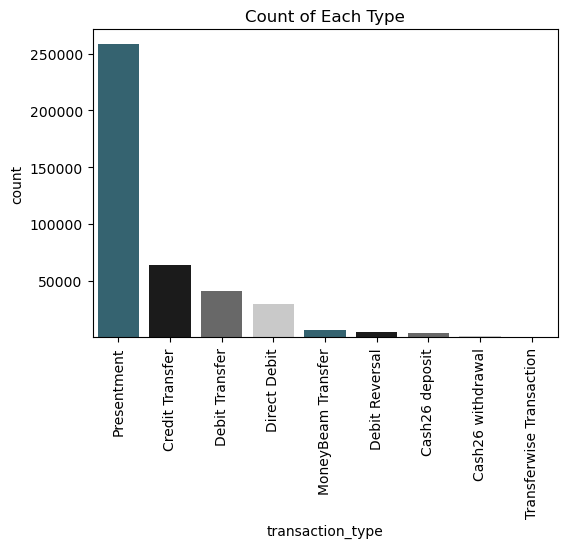

In [10]:
# Plot for 'explanation'
plot_bar('transaction_type', 'count', transactions_info, figsize=(6, 4), title='Count of Each Type', save_filename="transaction_type")

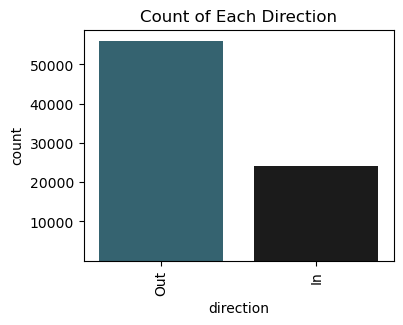

In [11]:
# Plot for 'direction'
plot_bar('direction', 'count', transactions_info, figsize=(4, 3), title='Count of Each Direction', save_filename="in-out-count")

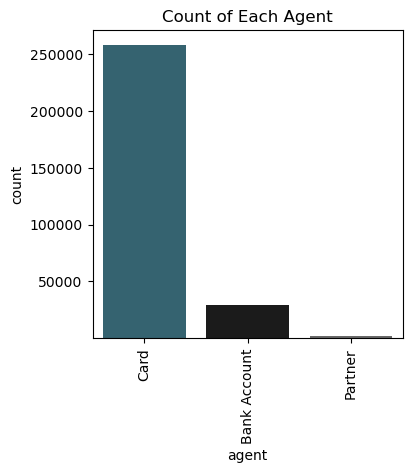

In [12]:
# Plot for 'agent'
plot_bar('agent', 'count', transactions_info, figsize=(4, 4), title='Count of Each Agent')

#### Findings

- "Presentment" transactions have an overwhelmingly high frequency (258,324), suggesting they are the most common type of transactions among N26 users. This could imply that card-based transactions are particularly popular among the user base.

- Transactions involving the bank account ("Credit Transfer", "Direct Debit", "Debit Transfer", etc.) also make up a significant portion of the dataset, with "Credit Transfer" being notably common at 63,837 counts. This suggests that traditional bank-based transactions are still prevalent among users.

- Transactions involving external partners like "Cash26" and "Transferwise" are much less frequent in comparison to other types. "Cash26 deposit" has 3,561 occurrences, while "Transferwise Transaction" has only 230. This could mean that while partner integrations are being used, they aren't as widely adopted as other transaction types.

- There's a notable distinction in the volume of "In" and "Out" transactions. The "In" transactions ("Cash26 deposit", "Credit Transfer", "Debit Reversal") are generally less frequent than the "Out" transactions ("Cash26 withdrawal", "Direct Debit", "Debit Transfer", "MoneyBeam Transfer", "Presentment", "Transferwise Transaction"), indicating that users are often spending more than they are receiving.

### Monthly precentage for presentment

In [13]:
df = data.copy()

# Convert 'transaction_date' to datetime type and extract the month and year
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_month_year'] = df['transaction_date'].dt.to_period('M')

# Group by 'transaction_month_year' and 'transaction_type', then count the occurrences
grouped_df = df.groupby(['transaction_month_year', 'transaction_type']).size().reset_index(name='count')

# Group by 'transaction_month_year' and sum the counts to get the total transactions per month
total_per_month = df.groupby(['transaction_month_year']).size().reset_index(name='total_count')

# Merge the two dataframes on 'transaction_month_year'
merged_df = pd.merge(grouped_df, total_per_month, on='transaction_month_year')

# Calculate the percentage for "Presentment" transactions
merged_df['percentage'] = (merged_df['count'] / merged_df['total_count']) * 100

# Filter to only show rows where 'transaction_type' is 'Presentment'
presentment_df = merged_df[merged_df['transaction_type'] == 'PT']

print(presentment_df)


   transaction_month_year transaction_type  count  total_count  percentage
7                 2016-02               PT  37322        59985   62.218888
16                2016-03               PT  42844        67600   63.378698
25                2016-04               PT  42825        68174   62.817203
34                2016-05               PT  46198        71834   64.312164
43                2016-06               PT  44044        69967   62.949676
52                2016-07               PT  45091        70986   63.520976


### transaction amount analysis

In [14]:
# Group by to get the sum of 'amount_n26_currency' for each 'type', 'explanation', 'direction', 'agent'
transactions_sum = merged_data.groupby(['type', 'explanation', 'direction', 'agent'])['amount_n26_currency'].sum().reset_index(name='total_amount')

# Renaming the 'explanation' column to 'transaction_type'
transactions_sum.rename(columns={'explanation': 'transaction_type'}, inplace=True)

transactions_sum

,type,transaction_type,direction,agent,total_amount
0,BBU,Cash26 deposit,In,Partner,402939
1,BUB,Cash26 withdrawal,Out,Partner,33515
2,CT,Credit Transfer,In,Bank Account,9457389
3,DD,Direct Debit,Out,Bank Account,902323
4,DR,Debit Reversal,In,Bank Account,162791
5,DT,Debit Transfer,Out,Bank Account,3628496
6,FT,MoneyBeam Transfer,Out,Bank Account,263142
7,PT,Presentment,Out,Card,6664191
8,TUB,Transferwise Transaction,Out,Partner,41802


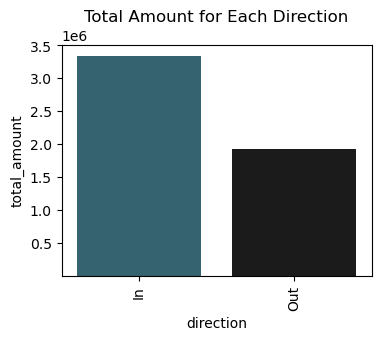

In [15]:
plot_bar('direction', 'total_amount', transactions_sum, figsize=(4, 3), title='Total Amount for Each Direction', save_filename="in-out-amount")

#### Findings

- The Credit Transfer transaction type under the In direction and handled by Bank Account has the highest total amount, with 9,457,389 units of currency. This suggests that the most significant incoming value for users is through bank-to-bank credit transfers.

- Comparatively, the highest outflow of money is via Presentment transactions through cards, amounting to 6,664,191 units of currency. This is nearly 70% of the amount that comes in via Credit Transfer, indicating a substantial volume of spending through card transactions.

- There is a notable imbalance between cash deposits (Cash26 deposit with 402,939 units) and cash withdrawals (Cash26 withdrawal with 33,515 units) when dealing with Partner as an agent. Cash deposits are more than 10 times the amount of cash withdrawals, pointing towards a behavior trend where users are more likely to deposit cash than to withdraw it.

- For Bank Account as the agent, Debit Transfer transactions are substantial in volume, with 3,628,496 units of currency going out. This amount is four times greater than the outgoing Direct Debit transactions (902,323 units), suggesting that users more commonly use debit transfers for larger amounts than direct debits.

### Monthly precentage for each direction

In [16]:
df = pd.DataFrame(data)

# Convert 'transaction_date' to datetime type and extract the month and year
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_month_year'] = df['transaction_date'].dt.to_period('M')

# Merge the df with transaction_types to get the direction
merged_df = pd.merge(df, transaction_types, left_on='transaction_type', right_on='type', how='left')

# Group by 'transaction_month_year', 'direction', and then sum the amounts and counts
grouped_df = merged_df.groupby(['transaction_month_year', 'direction']).agg({'amount_n26_currency': 'sum', 'user_id': 'count'}).reset_index().rename(columns={'user_id': 'count'})

# Group by 'transaction_month_year' and sum the counts and amounts to get the total per month
total_per_month = merged_df.groupby(['transaction_month_year']).agg({'amount_n26_currency': 'sum', 'user_id': 'count'}).reset_index().rename(columns={'user_id': 'total_count', 'amount_n26_currency': 'total_amount'})

# Merge the grouped_df and total_per_month dataframes on 'transaction_month_year'
final_df = pd.merge(grouped_df, total_per_month, on='transaction_month_year')

# Calculate the percentages within each month
final_df['percentage_count'] = (final_df['count'] / final_df['total_count']) * 100
final_df['percentage_amount'] = (final_df['amount_n26_currency'] / final_df['total_amount']) * 100

final_df

,transaction_month_year,direction,amount_n26_currency,count,total_amount,total_count,percentage_count,percentage_amount
0,2016-02,In,1507029,11476,3118699,59985,19.131450,48.322361
1,2016-02,Out,1611670,48509,3118699,59985,80.868550,51.677639
2,2016-03,In,1701743,12317,3577873,67600,18.220414,47.562979
3,2016-03,Out,1876130,55283,3577873,67600,81.779586,52.437021
4,2016-04,In,1690117,11995,3628088,68174,17.594684,46.584234
5,2016-04,Out,1937971,56179,3628088,68174,82.405316,53.415766
6,2016-05,In,1702528,12195,3715338,71834,16.976641,45.824310
7,2016-05,Out,2012810,59639,3715338,71834,83.023359,54.175690
8,2016-06,In,1705055,12114,3710907,69967,17.313877,45.947123
9,2016-06,Out,2005852,57853,3710907,69967,82.686123,54.052877


### Merchant Category Code (MCC) 

The Merchant Category Code (MCC) is only associated with the "Presentment" (PT) transaction type, which likely indicates that this is the only transaction type involving point-of-sale or online merchant transactions where categorizing the type of merchant is relevant or possible.

In [17]:
mcc_group_definition.head()

,mcc_group,explanation
0,1,ATM
1,2,Groceries
2,3,Gastronomie
3,4,Shopping/(Fashion)
4,5,"Home and DIY, House Energy"


In [18]:
# Rename the 'explanation' column to 'Merchant_Category'
mcc_group_definition.rename(columns={'explanation': 'merchant_category'}, inplace=True)

# Merge data DataFrame with mcc_group_definition DataFrame
merged_data = pd.merge(data[data['transaction_type'] == 'PT'], mcc_group_definition, on='mcc_group', how='left')

# Create mcc_analysis DataFrame by selecting specific columns
mcc_analysis = merged_data[['merchant_category', 'amount_n26_currency', 'transaction_date']]

# Group by 'merchant_category' to get the sum of 'amount_n26_currency' for each category
grouped_mcc_analysis = mcc_analysis.groupby('merchant_category')['amount_n26_currency'].sum().reset_index()

# Sort the grouped data by 'amount_n26_currency' in descending order for better visualization
grouped_mcc_analysis = grouped_mcc_analysis.sort_values('amount_n26_currency', ascending=False)

grouped_mcc_analysis

,merchant_category,amount_n26_currency
0,ATM,3054654
16,Travel/Hotel,717324
9,Groceries,556941
13,Shopping/(Fashion),500694
2,Business Expenses,354429
1,Automotive/Gas,332622
12,Miscellaneous,258558
8,Gastronomie,253713
15,Transport,243095
10,"Home and DIY, House Energy",117568


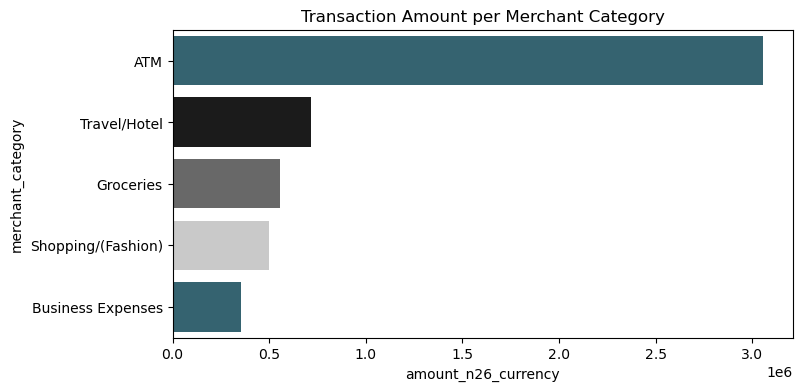

In [19]:
# Group by 'merchant_category' to get the sum of 'transaction_amount' for each category
grouped_data = mcc_analysis.groupby('merchant_category')['amount_n26_currency'].sum().reset_index()

# Sort the data by 'transaction_amount' in descending order for better visualization
grouped_data = grouped_data.sort_values('amount_n26_currency', ascending=False)

# Use the 'plot_bar' function to plot the data
plot_bar2(x='amount_n26_currency', 
         y='merchant_category', 
         data=grouped_data, 
         figsize=(8, 4), 
         title='Transaction Amount per Merchant Category', 
         rotation=0,
         save_filename="mcc-amount")

### Findings

- ATM Dominance: The "ATM" category accounts for the highest transaction amount, significantly outpacing all other categories. This could imply that a substantial portion of the financial activity is in cash withdrawals.

- Travel and Groceries are Key Spending Areas: The next two categories with the highest transaction amounts are "Travel/Hotel" and "Groceries". This suggests that travel-related expenses and daily essentials are other major areas where users are spending money.

- Lower Spending in Certain Categories: Categories like "Insurance", "Taxes and Fines", and "Family/Babies/Children" have notably lower transaction amounts. This could either indicate that these expenses are less frequent or typically smaller in magnitude.

- Non-Essential Expenses: Spending in categories like "Shopping/(Fashion)" and "Entertainment/Leisure" is noticeable but not as high as in essential or obligatory categories like "ATM" or "Groceries". This could provide an interesting angle for budgeting or financial wellness features.

## Trends & Seasonality

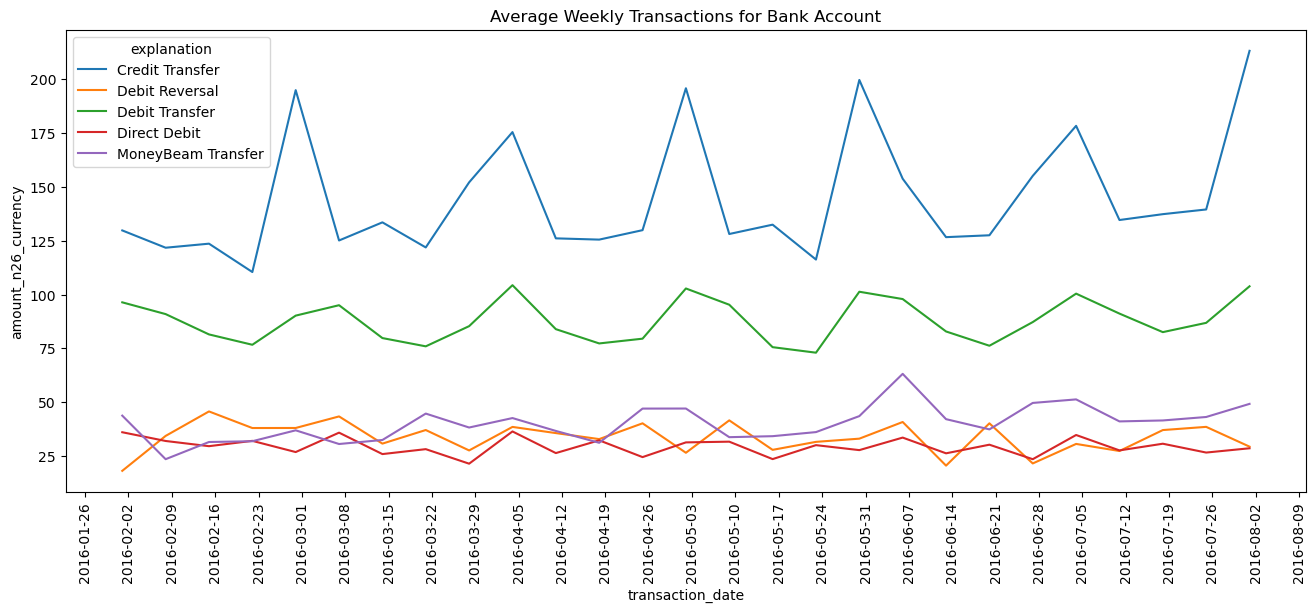

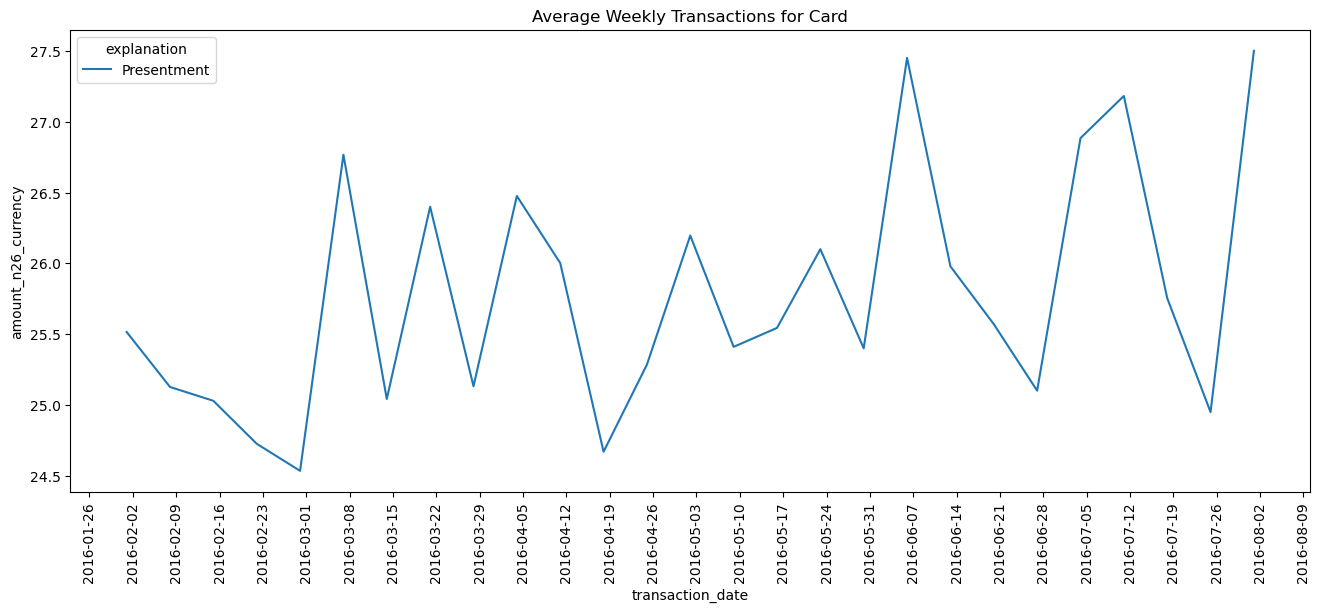

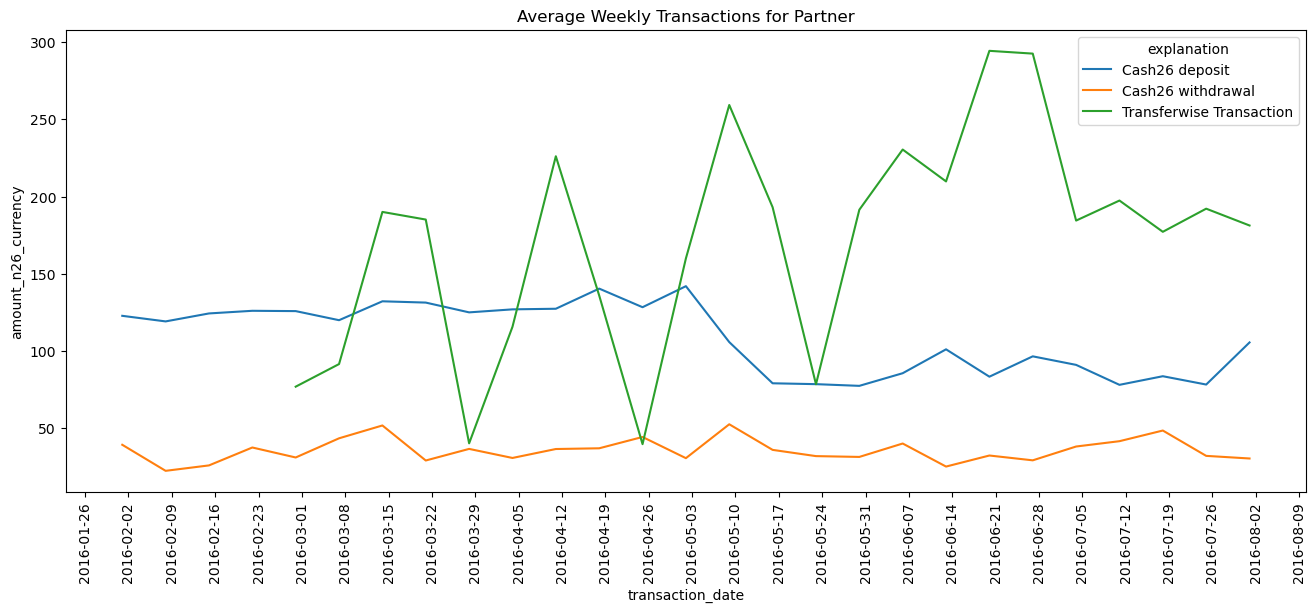

In [20]:
# Merge the dataframes
merged_data = pd.merge(data, transaction_types, left_on='transaction_type', right_on='type', how='left')

# Convert transaction_date to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])

# Group by 'agent', 'type', and 'transaction_date' then resample to weekly frequency
grouped_data = (merged_data
                .groupby(['agent', 'explanation', pd.Grouper(key='transaction_date', freq='W-MON')])
                ['amount_n26_currency']
                .mean()
                .reset_index())

# Plotting
for agent in grouped_data['agent'].unique():
    plt.figure(figsize=(16, 6))
    sns.lineplot(x='transaction_date', y='amount_n26_currency', hue='explanation', 
                 data=grouped_data[grouped_data['agent'] == agent])
    
    # Set x-ticks to be weekly
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    plt.title(f'Average Weekly Transactions for {agent}')
    plt.show()

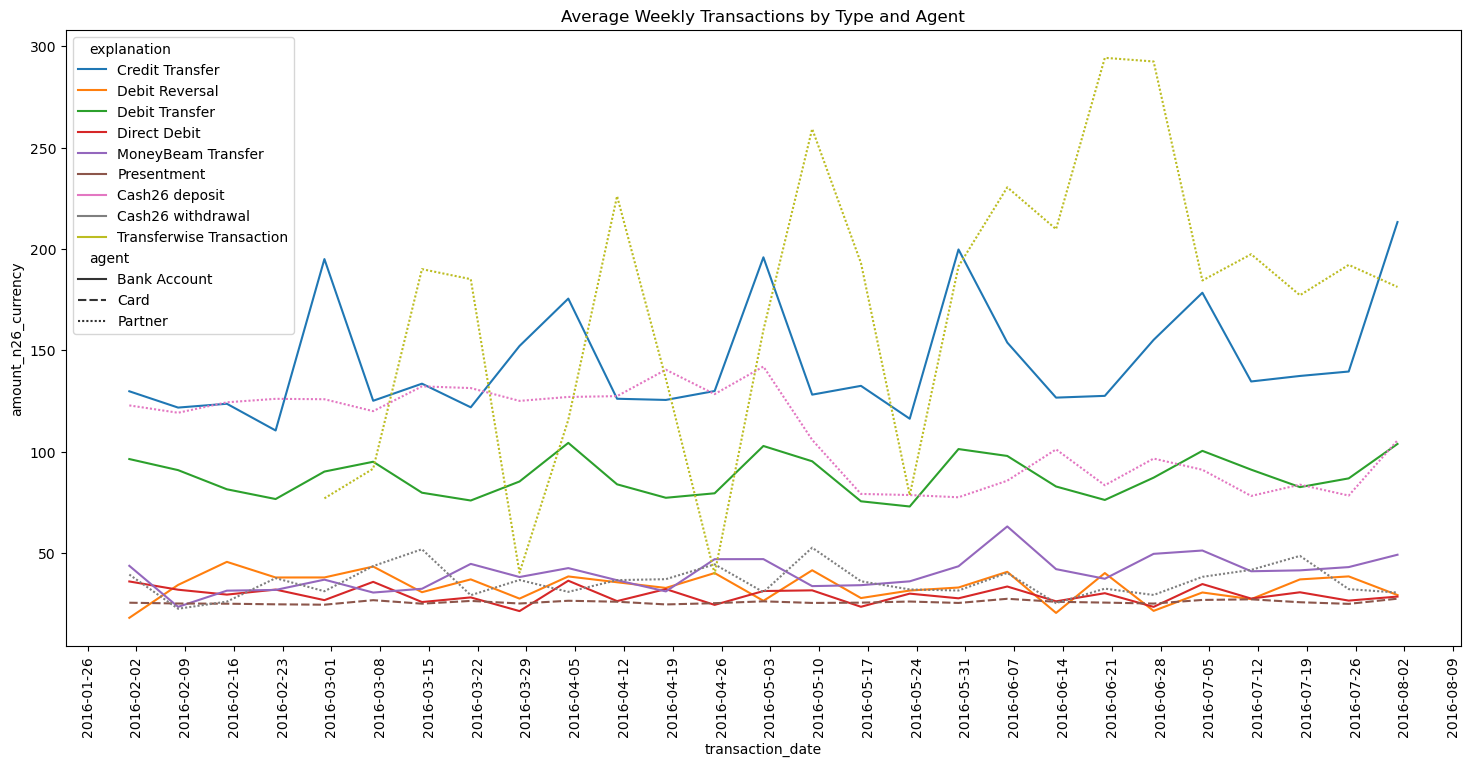

In [21]:
plt.figure(figsize=(18, 8))

sns.lineplot(x='transaction_date', y='amount_n26_currency', hue='explanation', style='agent',
             data=grouped_data)

# Set x-ticks to be weekly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.title('Average Weekly Transactions by Type and Agent')
plt.show()


## Trends for Presentment

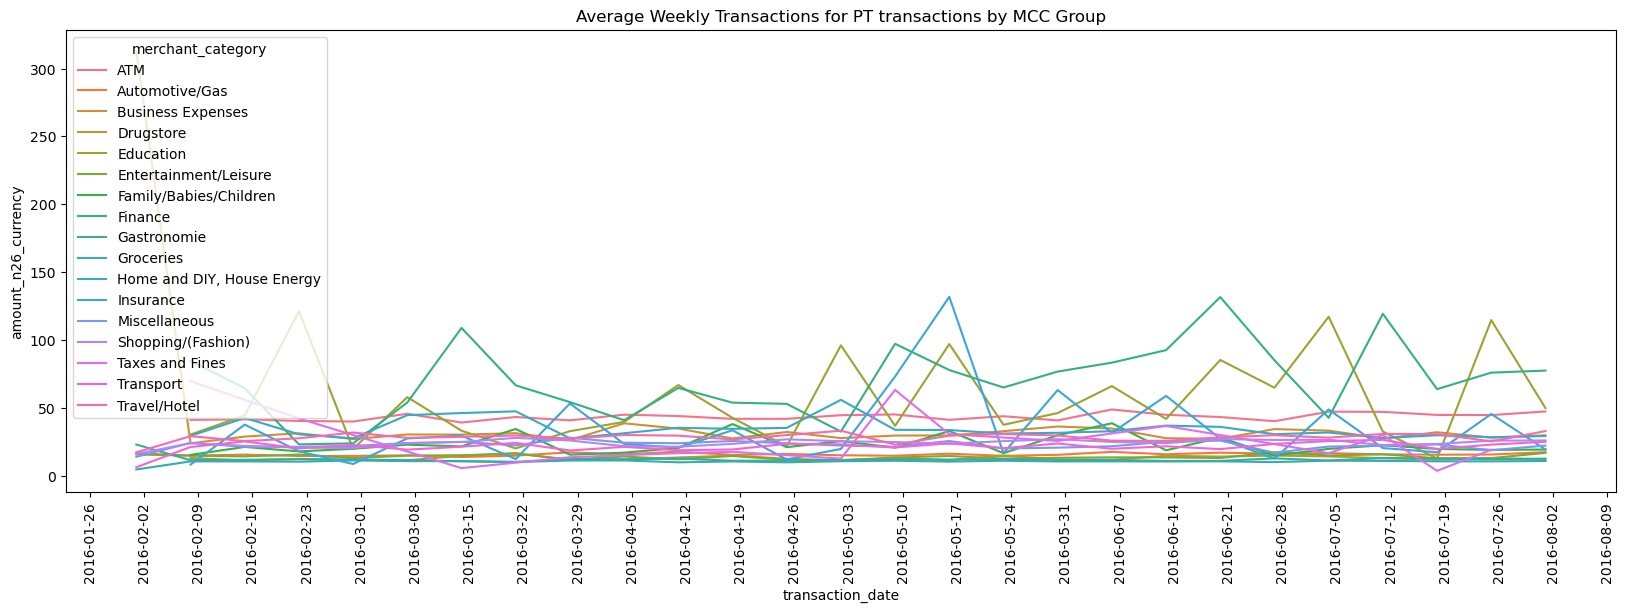

In [22]:
# Filter for transactions of type 'PT'
pt_data = data[data['transaction_type'] == 'PT']

# Merge the filtered DataFrame with the mcc_group_definition DataFrame
merged_data = pd.merge(pt_data, mcc_group_definition, on='mcc_group', how='left')

# Convert transaction_date to datetime type
merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])

# Group by 'explanation' and 'transaction_date', then resample to weekly frequency
grouped_data = (merged_data
                .groupby(['merchant_category', pd.Grouper(key='transaction_date', freq='W-MON')])
                ['amount_n26_currency']
                .mean()
                .reset_index())

# Plotting
plt.figure(figsize=(20, 6))
sns.lineplot(x='transaction_date', y='amount_n26_currency', hue='merchant_category',
             data=grouped_data)
plt.title('Average Weekly Transactions for PT transactions by MCC Group')

# Additional code to set x-ticks to be weekly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

### Single Account analysis

/var/folders/j_/r9p377l96x53wfwmdtb_19p40000gn/T/ipykernel_30860/91671515.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(x='transaction_date', y='amount_n26_currency', hue='direction',


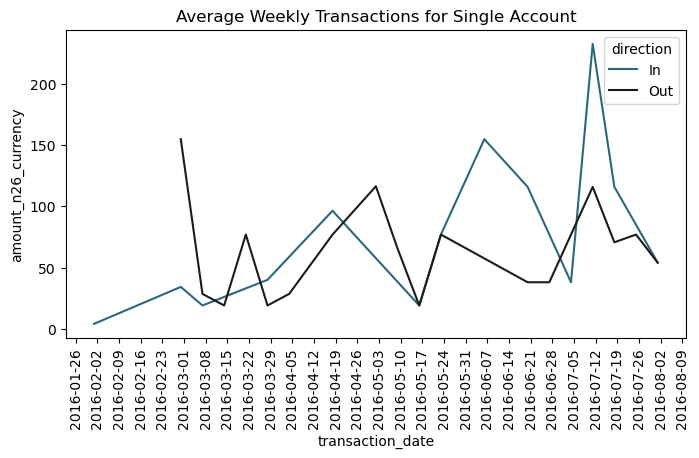

In [23]:
# Merge the dataframes
merged_data = pd.merge(data, transaction_types, left_on='transaction_type', right_on='type', how='left')

# Convert transaction_date to datetime
merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])

# Filter by specific user_id
chosen_user_id = "0ae72254be285bf66be677b47b29ec95" 
filtered_data = merged_data[merged_data['user_id'] == chosen_user_id]

# Group by 'direction', 'transaction_date' and then resample to weekly frequency
grouped_data = (filtered_data
                .groupby(['direction', pd.Grouper(key='transaction_date', freq='W-MON')])
                ['amount_n26_currency']
                .mean()
                .reset_index())

# Plotting
plt.figure(figsize=(8, 4))
sns.lineplot(x='transaction_date', y='amount_n26_currency', hue='direction', 
             data=grouped_data, palette=['#2b697a', '#1B1B1B', '#686868', '#C9C9C9'])

# Set x-ticks to be weekly
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.title(f'Average Weekly Transactions for Single Account')
plt.show()


### Findings

- A notable increase in both credit and debit transfers is observed at the end of each month, possibly suggesting a pattern linked to month-end financial activities.

- Starting from April 2016, there is a consistent weekly upward trend in the average amount of Transferwise transactions, indicating increased usage or higher-value transactions over time.

- A prominent peak in transaction activity is evident in the last week of every month. Specifically, credit transfers experience a significant surge during this period, which may be indicative of salary credits or other end-of-month financial settlements.

## ✨&nbsp; Data prepration

### Approach
- First, for each user/month, I generated the following set of features:
    - Minimum transaction amount
    - Maximum transaction amount
    - Average transaction amount
    - Frequency of transactions
    - Income/expenses from the previous month
- I used the income for the following month as the target variable for my model.
- My goal is to predict next month's income based on the current month's transactions.
    - Prediction Point: I make monthly predictions for each user.
    - Time Horizon: I base predictions on the previous month's data.

In [24]:
data_df = data.merge(transaction_types, left_on='transaction_type', right_on='type', how='left')

# Convert 'transaction_date' to datetime type
data_df['transaction_date'] = pd.to_datetime(data_df['transaction_date'])

# Extract month and day from the transaction_date
data_df['month'] = data_df['transaction_date'].dt.month
data_df['day'] = data_df['transaction_date'].dt.day

# Group by 'user_id', 'month', 'day', and 'direction', and sum the 'amount_n26_currency'
grouped_df = data_df.groupby(['user_id', 'month', 'direction'])['amount_n26_currency'].sum().reset_index()

# Pivot the table to have 'income' and 'expenses' columns
pivot_df = grouped_df.pivot(index=['user_id', 'month'], columns='direction', values='amount_n26_currency').reset_index()

# Rename the columns
pivot_df.rename(columns={'In': 'income', 'Out': 'expenses'}, inplace=True)

pivot_df.head()

direction,user_id,month,income,expenses
0,000295594379774ab9ac2c78c946d615,2,291.0,280.0
1,000295594379774ab9ac2c78c946d615,3,381.0,391.0
2,000295594379774ab9ac2c78c946d615,5,155.0,154.0
3,000295594379774ab9ac2c78c946d615,6,115.0,68.0
4,000295594379774ab9ac2c78c946d615,7,NaN,9.0


In [25]:
# Number of unique users with NaN income
num_users_with_nan_income = pivot_df[pivot_df['income'].isna()]['user_id'].nunique()

# Total number of unique users
total_num_users = pivot_df['user_id'].nunique()

# Calculate percentage
percentage_users_with_nan_income = (num_users_with_nan_income / total_num_users) * 100

print(f"The percentage of unique users with NaN income values is {percentage_users_with_nan_income}%")

The percentage of unique users with NaN income values is 64.47%


In [26]:
def percentage_of_nan_users(pivot_df, column_name):
    # Filter rows where the specified column is NaN
    df_nan = pivot_df[pivot_df[column_name].isna()]

    # Count unique user_ids with NaN values per month
    count_nan_per_month = df_nan.groupby('month')['user_id'].nunique()

    # Count unique user_ids per month in the original dataframe
    total_users_per_month = pivot_df.groupby('month')['user_id'].nunique()

    # Calculate the percentage
    percentage_nan_per_month = (count_nan_per_month / total_users_per_month) * 100

    print(f"Percentage of unique users with NaN {column_name} values per month:")
    print(percentage_nan_per_month)

# Calculate for income
percentage_of_nan_users(pivot_df, 'income')

print("####################")

# Calculate for expenses
percentage_of_nan_users(pivot_df, 'expenses')


Percentage of unique users with NaN income values per month:
month
2    27.058987
3    26.216725
4    27.046744
5    26.215559
6    27.115437
7    26.868906
Name: user_id, dtype: float64
####################
Percentage of unique users with NaN expenses values per month:
month
2    8.458542
3    7.717128
4    7.187247
5    7.158293
6    7.082995
7    7.218310
Name: user_id, dtype: float64


Number of unique users in month 3 who had no income in the previous month 2: 1350
Number of unique users in month 4 who had no income in the previous month 3: 1360
Number of unique users in month 5 who had no income in the previous month 4: 1393
Number of unique users in month 6 who had no income in the previous month 5: 1328
Number of unique users in month 7 who had no income in the previous month 6: 1384
Number of unique users in month 3 who had no expenses in the previous month 2: 531
Number of unique users in month 4 who had no expenses in the previous month 3: 488
Number of unique users in month 5 who had no expenses in the previous month 4: 457
Number of unique users in month 6 who had no expenses in the previous month 5: 455
Number of unique users in month 7 who had no expenses in the previous month 6: 450


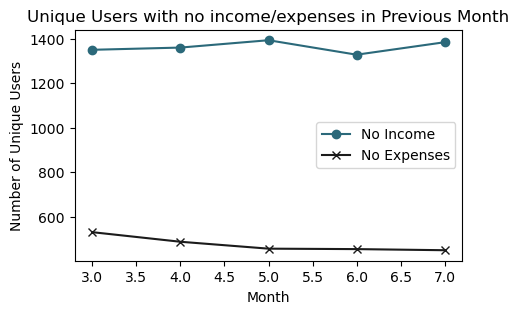

In [27]:
def analyze_nan_values(pivot_df, value_column):
    # Initialize an empty dictionary to hold user_ids with NaN values for each month
    nan_value_users_by_month = {}
    
    # Loop over each unique month in the DataFrame
    for month in pivot_df['month'].unique():
        # Filter the DataFrame for the given month and NaN values
        df_filtered = pivot_df[(pivot_df['month'] == month) & pivot_df[value_column].isna()]
        
        # Get the unique user_ids for this filtered DataFrame
        unique_users = df_filtered['user_id'].unique()
        
        # Store in the dictionary
        nan_value_users_by_month[month] = set(unique_users)
    
    # To find users who had NaN values in the previous month but not the current month, use set operations
    sorted_months = sorted(nan_value_users_by_month.keys())
    differences = []
    
    for i in range(1, len(sorted_months)):
        current_month = sorted_months[i]
        prev_month = sorted_months[i - 1]
        
        # Users with NaN values in the previous month but not in the current month
        difference = nan_value_users_by_month[prev_month].difference(nan_value_users_by_month[current_month])
        differences.append(len(difference))
        
        print(f"Number of unique users in month {current_month} who had no {value_column} in the previous month {prev_month}: {len(difference)}")
    
    return sorted_months[1:], differences

# Analyze NaN income and expenses
months, nan_income_differences = analyze_nan_values(pivot_df, 'income')
_, nan_expenses_differences = analyze_nan_values(pivot_df, 'expenses')

#['#2b697a', '#1B1B1B', '#686868', '#C9C9C9']

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(months, nan_income_differences, marker='o', label='No Income', color='#2b697a')
plt.plot(months, nan_expenses_differences, marker='x', label='No Expenses', color='#1B1B1B')
plt.xlabel('Month')
plt.ylabel('Number of Unique Users')
plt.title('Unique Users with no income/expenses in Previous Month')
plt.legend()
plt.show()


### Finidngs

- ~25% unique users per month do not have any incoming transcations
- ~7% of unique per month users do not have any outgoing transcations in some months

## 📦&nbsp; Feature Engineering

In [28]:
def generate_features(data, transaction_types):
    data_copy = data.copy()
    data_df = data_copy.merge(transaction_types, left_on='transaction_type', right_on='type', how='left')
    data_df['transaction_date'] = pd.to_datetime(data_df['transaction_date'])
    data_df['month'] = data_df['transaction_date'].dt.month
    
    income_df = data_df[data_df['direction'] == 'In']
    expenses_df = data_df[data_df['direction'] == 'Out']
    
    def calculate_features(df, value_col):
        grouped_by_month = df.groupby(['user_id', 'month'])[value_col].agg(['min', 'max', 'mean', 'std', 'count']).reset_index()
        grouped_by_month.rename(columns={'count': 'frequency'}, inplace=True)

        # Create a DataFrame that has all months for all users
        users = grouped_by_month['user_id'].unique()
        all_months = range(2, 8)
        index = pd.MultiIndex.from_product([users, all_months], names=['user_id', 'month'])
        full_df = pd.DataFrame(index=index).reset_index()

        # Merge this DataFrame with the original grouped_by_month DataFrame
        merged_df = pd.merge(full_df, grouped_by_month, on=['user_id', 'month'], how='left').fillna(0)
        
        # Calculate previous_month_value
        merged_df['previous_month_value'] = merged_df.groupby('user_id')['mean'].shift().fillna(0)
        
        return merged_df
    
    income_features_df = calculate_features(income_df, 'amount_n26_currency')
    expenses_features_df = calculate_features(expenses_df, 'amount_n26_currency')
    
    return income_features_df, expenses_features_df


In [29]:
income_features_df, expenses_features_df = generate_features(data, transaction_types)

In [30]:
income_features_df.head()

,user_id,month,min,max,mean,std,frequency,previous_month_value
0,000295594379774ab9ac2c78c946d615,2,291.0,291.0,291.0,0.0,1.0,0.0
1,000295594379774ab9ac2c78c946d615,3,381.0,381.0,381.0,0.0,1.0,291.0
2,000295594379774ab9ac2c78c946d615,4,0.0,0.0,0.0,0.0,0.0,381.0
3,000295594379774ab9ac2c78c946d615,5,155.0,155.0,155.0,0.0,1.0,0.0
4,000295594379774ab9ac2c78c946d615,6,115.0,115.0,115.0,0.0,1.0,155.0


In [31]:
def get_monthly_sum_by_direction(data, transaction_types, direction):
    # Merge dataframes and convert 'transaction_date' to datetime type
    merged_data = data.merge(transaction_types, left_on='transaction_type', right_on='type', how='left')
    merged_data['transaction_date'] = pd.to_datetime(merged_data['transaction_date'])
    
    # Extract month from the transaction_date
    merged_data['month'] = merged_data['transaction_date'].dt.month
    
    # Filter for the direction ('In' for income, 'Out' for expenses)
    filtered_data = merged_data[merged_data['direction'] == direction]
    
    # Group by user_id and month to get the sum
    monthly_sum = filtered_data.groupby(['user_id', 'month'])['amount_n26_currency'].sum().reset_index()
    
    # Create a 'target_month' column, which is the month for which this sum will serve as the target variable
    monthly_sum['target_month'] = monthly_sum['month'] - 1
    
    # Rename the sum column
    monthly_sum.rename(columns={'amount_n26_currency': f'{direction.lower()}_next_month'}, inplace=True)
    
    return monthly_sum


In [32]:
def add_target_column(features_df, data, transaction_types, direction):
    # Get the monthly sum by direction ('In' for income, 'Out' for expenses)
    monthly_sum = get_monthly_sum_by_direction(data, transaction_types, direction)
    
    
    # Merge with the features_df to create a target column
    merged_df = pd.merge(features_df, monthly_sum, 
                         left_on=['user_id', 'month'], 
                         right_on=['user_id', 'target_month'], 
                         how='left').drop(columns=['month_y', 'target_month'])
    
    merged_df.rename(columns={'month_x': 'month'}, inplace=True)
    
    return merged_df


In [33]:
income_with_target = add_target_column(income_features_df, data, transaction_types, 'In')
expenses_with_target = add_target_column(expenses_features_df, data, transaction_types, 'Out')

In [34]:
income_with_target[income_with_target['user_id'] == '000aa792d73dd82b16a29692772d395a']

,user_id,month,min,max,mean,std,frequency,previous_month_value,in_next_month
6,000aa792d73dd82b16a29692772d395a,2,0.0,0.0,0.0,0.000000,0.0,0.0,NaN
7,000aa792d73dd82b16a29692772d395a,3,0.0,0.0,0.0,0.000000,0.0,0.0,NaN
8,000aa792d73dd82b16a29692772d395a,4,0.0,0.0,0.0,0.000000,0.0,0.0,660.0
9,000aa792d73dd82b16a29692772d395a,5,77.0,583.0,330.0,357.796031,2.0,0.0,NaN
10,000aa792d73dd82b16a29692772d395a,6,0.0,0.0,0.0,0.000000,0.0,330.0,155.0
11,000aa792d73dd82b16a29692772d395a,7,155.0,155.0,155.0,0.000000,1.0,0.0,NaN


In [35]:
# Replace NaNs in 'In_previous_month' with zeros, but leave the NaNs where month==2
income_with_target.loc[income_with_target['month'] != 2, 'in_next_month'] = \
    income_with_target.loc[income_with_target['month'] != 2, 'in_next_month'].fillna(0)

# Replace NaNs in 'Out_previous_month' with zeros, but leave the NaNs where month==2
expenses_with_target.loc[expenses_with_target['month'] != 2, 'out_next_month'] = \
    expenses_with_target.loc[expenses_with_target['month'] != 2, 'out_next_month'].fillna(0)


In [36]:
def prepare_data(dataframe, months_train, months_test, columns_to_scale):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Scale features
    dataframe[columns_to_scale] = scaler.fit_transform(dataframe[columns_to_scale])
    
    # Convert months to lists for concatenation
    months_train_list = [months_train] if isinstance(months_train, int) else list(range(months_train[0], months_train[1] + 1))
    months_test_list = [months_test] if isinstance(months_test, int) else list(range(months_test[0], months_test[1] + 1))

    # Filter out rows where month is not in the train or test range, and make an explicit copy
    dataframe = dataframe[dataframe['month'].isin(months_train_list + months_test_list)].copy()

    # Sort by 'month' and 'user_id'
    dataframe.sort_values(by=['month', 'user_id'], inplace=True)

    # Create train and test dataframes based on passed month ranges
    train_df = dataframe[dataframe['month'].isin(months_train_list)].copy()
    test_df = dataframe[dataframe['month'].isin(months_test_list)].copy()

    # Drop the 'month' column for the train and test dataframes
    train_df.drop('month', axis=1, inplace=True)
    test_df.drop('month', axis=1, inplace=True)

    return train_df, test_df

In [37]:
columns_to_scale = ['min', 'max', 'mean', 'std', 'frequency', 'previous_month_value']
train_income, test_income = prepare_data(income_with_target, (3, 5), 6, columns_to_scale)
train_expenses, test_expenses = prepare_data(expenses_with_target, (3, 5), 6, columns_to_scale)

### Checking records for one user

In [38]:
train_expenses[train_expenses['user_id'] == '000295594379774ab9ac2c78c946d615']

,user_id,min,max,mean,std,frequency,previous_month_value,out_next_month
1,000295594379774ab9ac2c78c946d615,0.001096,2.024836,1.399924,3.225104,-0.220688,5.470795,0.0
2,000295594379774ab9ac2c78c946d615,-0.272009,-0.563038,-0.512276,-0.496643,-0.714346,1.611936,154.0
3,000295594379774ab9ac2c78c946d615,-0.098215,0.536434,0.994010,1.729112,-0.467517,-0.457767,68.0


In [39]:
test_expenses[test_expenses['user_id'] == '000295594379774ab9ac2c78c946d615']

,user_id,min,max,mean,std,frequency,previous_month_value,out_next_month
4,000295594379774ab9ac2c78c946d615,-0.172698,-0.278821,-0.290571,-0.201546,0.026141,1.172587,9.0


In [40]:
random_user = data.merge(transaction_types, left_on='transaction_type', right_on='type', how='left')
random_user = random_user[random_user['direction'] == 'Out']

random_user = random_user[random_user['user_id'] == '000295594379774ab9ac2c78c946d615']
random_user

,user_id,transaction_date,transaction_type,mcc_group,amount_n26_currency,dataset_transaction,dataset_user,type,explanation,direction,agent
43238,000295594379774ab9ac2c78c946d615,2016-02-21,PT,1.0,280,training,training,PT,Presentment,Out,Card
64359,000295594379774ab9ac2c78c946d615,2016-03-01,DT,NaN,11,training,training,DT,Debit Transfer,Out,Bank Account
87497,000295594379774ab9ac2c78c946d615,2016-03-12,PT,1.0,19,training,training,PT,Presentment,Out,Card
87498,000295594379774ab9ac2c78c946d615,2016-03-12,PT,1.0,15,training,training,PT,Presentment,Out,Card
87499,000295594379774ab9ac2c78c946d615,2016-03-12,PT,1.0,346,training,training,PT,Presentment,Out,Card
212098,000295594379774ab9ac2c78c946d615,2016-05-10,DT,NaN,7,training,training,DT,Debit Transfer,Out,Bank Account
226140,000295594379774ab9ac2c78c946d615,2016-05-12,PT,1.0,147,training,training,PT,Presentment,Out,Card
286168,000295594379774ab9ac2c78c946d615,2016-06-09,PT,1.0,7,training,training,PT,Presentment,Out,Card
297251,000295594379774ab9ac2c78c946d615,2016-06-18,PT,1.0,7,training,training,PT,Presentment,Out,Card
310556,000295594379774ab9ac2c78c946d615,2016-06-17,PT,6.0,4,training,training,PT,Presentment,Out,Card


# 🤖&nbsp; Modeling

### Approach
- I used two different models for the reasons below:
    - Each model can specialize in capturing the unique dynamics and features relevant to either income or expenses.
    - Separate models may offer better performance if income and expenses are influenced by significantly different factors.
    - It may be easier to interpret and explain models that only focus on one aspect of the data.

In [41]:
def evaluate_model(y_test, predictions):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    # Calculate RMSLE (avoid negative predictions)
    rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(np.maximum(0, predictions))))
    
    # Calculate R-squared
    r2 = r2_score(y_test, predictions)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Calculate MAPE (avoid division by zero and exclude those cases)
    non_zero_idx = y_test != 0
    mape = np.mean(np.abs((y_test[non_zero_idx] - predictions[non_zero_idx]) / y_test[non_zero_idx])) * 100
    
    # Return the metrics
    return {
        'RMSE': rmse,
        'RMSLE': rmsle,
        'R-squared': r2,
        'MAE': mae,
        'MAPE': mape
    }


# 🧪 Data leakge

- To prevent data leakage, it's crucial to train the model only using data up to May and then test it using June's data.
- Including June in the training set would introduce bias, as June's target column contains information about income and expenses for July. This would give the model unfair advance knowledge of the outcomes it's supposed to predict.

# 🚂&nbsp; Model 1 (Linear Regression)

In [42]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

ms = make_scorer(rmsle, greater_is_better=False)

### For Income

In [43]:
# Prepare feature matrix X and target vector y for training
X_train_income = train_income.drop(['user_id', 'in_next_month'], axis=1)
y_train_income = train_income['in_next_month']

# Prepare feature matrix X and target vector y for testing
X_test_income = test_income.drop(['user_id', 'in_next_month'], axis=1)
y_test_income = test_income['in_next_month']

# Initialize and train the model
model_lr_in = LinearRegression()
model_lr_in.fit(X_train_income, y_train_income)


# Make predictions on test set
y_pred_in = model_lr_in.predict(X_test_income)

### For expenses

In [44]:
# Prepare feature matrix X and target vector y for training
X_train_expenses = train_expenses.drop(['user_id', 'out_next_month'], axis=1)
y_train_expenses = train_expenses['out_next_month']

# Prepare feature matrix X and target vector y for testing
X_test_expenses = test_expenses.drop(['user_id', 'out_next_month'], axis=1)
y_test_expenses = test_expenses['out_next_month']

# Initialize and train the model
model_lr_out = LinearRegression()
model_lr_out.fit(X_train_expenses, y_train_expenses)


# Make predictions
y_pred_out = model_lr_out.predict(X_test_expenses)

# ⚖️&nbsp; Evaluation 1 (Linear Regression)

### For Income

In [45]:
metrics = evaluate_model(y_test_income, y_pred_in)

# Print the evaluation metrics
print(f"RMSE: {metrics['RMSE']}")
print(f"RMSLE: {metrics['RMSLE']}")
print(f"R-squared: {metrics['R-squared']}")
print(f"MAE: {metrics['MAE']}")
print(f"MAPE: {metrics['MAPE']}%")

RMSE: 280.496298476004
RMSLE: 3.1471075691655153
R-squared: 0.2622098720646553
MAE: 174.68869493493114
MAPE: 219.65857721216997%


In [46]:
# Use RMSLE as the metric
scores = cross_val_score(model_lr_in, X_train_income, y_train_income, cv=5, scoring=ms)
avg_cross_val_score = np.mean(-scores)

print(f"Average Cross-Validation RMSLE: {avg_cross_val_score}")

Average Cross-Validation RMSLE: 3.1460058109292697


### For Expenses

In [47]:
metrics = evaluate_model(y_test_expenses, y_pred_out)

# Print the evaluation metrics
print(f"RMSE: {metrics['RMSE']}")
print(f"RMSLE: {metrics['RMSLE']}")
print(f"R-squared: {metrics['R-squared']}")
print(f"MAE: {metrics['MAE']}")
print(f"MAPE: {metrics['MAPE']}%")

RMSE: 306.6356002610021
RMSLE: 2.2930264315361057
R-squared: 0.45372719674487527
MAE: 151.17404517998668
MAPE: 216.17225821724765%


In [48]:
# Use RMSLE as the metric
scores = cross_val_score(model_lr_out, X_train_expenses, y_train_expenses, cv=5, scoring=ms)
avg_cross_val_score = np.mean(-scores)

print(f"Average Cross-Validation RMSLE: {avg_cross_val_score}")

Average Cross-Validation RMSLE: 2.3034524875092623


### Finidngs
- Linear regression is performing poorly, especially on the income dataset. A baseline model that predicts the average would yield better results in this case.
- As for expenses, the model's performance is still subpar but better than its performance on the income dataset. This discrepancy could be because the features used for predicting expenses could be more informative or relevant than those used for income or the expense data has less variability or is more normally distributed.

# 🚂&nbsp; Model 2 (XGBoost)

### For Income

In [49]:
# Selecting features and target variable for income
X_train_income = train_income.drop(['user_id', 'in_next_month'], axis=1)
y_train_income = train_income['in_next_month']

# Prepare the testing data
X_test_income = test_income.drop(['user_id', 'in_next_month'], axis=1)
y_test_income = test_income['in_next_month']

# Initialize and train the model
income_model_xgb = xgb.XGBRegressor()
income_model_xgb.fit(X_train_income, y_train_income)

# Make predictions on the test set
y_pred_income_xgb = income_model_xgb.predict(X_test_income)

### For Expenses

In [50]:
# Selecting features and target variable for income
X_train_expenses = train_expenses.drop(['user_id', 'out_next_month'], axis=1)
y_train_expenses = train_expenses['out_next_month']

# Prepare the testing data
X_test_expenses = test_expenses.drop(['user_id', 'out_next_month'], axis=1)
y_test_expenses = test_expenses['out_next_month']

# Initialize and fit the model
expenses_model_xgb = xgb.XGBRegressor()
expenses_model_xgb.fit(X_train_expenses, y_train_expenses)

# Making predictions on training set (not yet evaluated)
y_pred_expenses_xgb = expenses_model_xgb.predict(X_test_expenses)

In [51]:
X_train_expenses

,min,max,mean,std,frequency,previous_month_value
1,0.001096,2.024836,1.399924,3.225104,-0.220688,5.470795
7,0.398339,-0.361094,0.015902,-0.496643,-0.590932,0.476889
13,0.398339,-0.361094,0.015902,-0.496643,-0.590932,-0.457767
19,5.512845,1.179663,4.045704,-0.496643,-0.590932,3.459318
25,0.025923,-0.076877,0.133275,-0.021465,0.149555,0.233898
...,...,...,...,...,...,...
58095,-0.272009,-0.563038,-0.512276,-0.496643,-0.714346,-0.224859
58101,-0.172698,-0.473285,-0.355778,-0.369457,-0.467517,-0.288380
58107,-0.098215,0.581311,0.535697,0.701672,0.149555,0.484451
58113,-0.123043,-0.458326,-0.336216,-0.398640,-0.344103,-0.261913


# ⚖️&nbsp; Evaluation 2 (XGBoost)

### For Income

In [52]:
metrics = evaluate_model(y_test_income, y_pred_income_xgb)

# Print the evaluation metrics
print(f"RMSE: {metrics['RMSE']}")
print(f"RMSLE: {metrics['RMSLE']}")
print(f"R-squared: {metrics['R-squared']}")
print(f"MAE: {metrics['MAE']}")
print(f"MAPE: {metrics['MAPE']}%")

RMSE: 288.0977131487113
RMSLE: 3.13666405399292
R-squared: 0.22167999587996257
MAE: 174.34301520364502
MAPE: 210.33721116117246%


### For Expenses

In [53]:
metrics = evaluate_model(y_test_expenses, y_pred_expenses_xgb)

# Print the evaluation metrics
print(f"RMSE: {metrics['RMSE']}")
print(f"RMSLE: {metrics['RMSLE']}")
print(f"R-squared: {metrics['R-squared']}")
print(f"MAE: {metrics['MAE']}")
print(f"MAPE: {metrics['MAPE']}%")

RMSE: 305.81278339491166
RMSLE: 2.447223461847176
R-squared: 0.45665496776465897
MAE: 154.19439086528143
MAPE: 220.59528165532876%


# ⚙️&nbsp; Fine Tuning

I will fine-tune only XGBoost

### For Income

In [54]:
# Objective function for hyperparameter optimization
def objective(params, X_train, y_train, X_test, y_test):
    # Initialize and train the model
    clf = xgb.XGBRegressor(**params, objective='reg:squarederror')
    clf.fit(X_train, y_train)

    # Make predictions
    preds = clf.predict(X_test)

    # Evaluate the model using your new evaluate_model function
    metrics = evaluate_model(y_test, preds)

    # Here, we are using RMSE as the loss function to minimize
    return {'loss': metrics['RMSE'], 'status': STATUS_OK}

In [55]:
# Define the hyperparameter space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'n_estimators': hp.choice('n_estimators', range(50, 300))
}

# Run the optimization
trials = Trials()
best_model_income = fmin(fn=lambda params: objective(params, X_train_income, y_train_income, X_test_income, y_test_income),
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.06s/trial, best loss: 275.7838956205119]


In [56]:
# Extract best hyperparameters from 'best' dictionary
best_params_in = {
    'learning_rate': best_model_income['learning_rate'],
    'max_depth': best_model_income['max_depth'],
    'n_estimators': best_model_income['n_estimators'],
    'objective': 'reg:squarederror'
}

# Initialize and train the best model
best_model_in = xgb.XGBRegressor(**best_params_in)
best_model_in.fit(X_train_income, y_train_income)

# Make predictions on the test set
y_pred_best_in = best_model_in.predict(X_test_income)

# Evaluate the best model
best_model_metrics = evaluate_model(y_test_income, y_pred_best_in)

# Print the metrics
for key, value in best_model_metrics.items():
    print(f"{key}: {value}")


RMSE: 277.29001705805666
RMSLE: 3.153369351921207
R-squared: 0.2789804513479017
MAE: 172.8248580286398
MAPE: 212.01399243000685


### For Expenses

In [57]:
# Define the hyperparameter space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'n_estimators': hp.choice('n_estimators', range(50, 300))
}

# Run the optimization
trials = Trials()
best_model_expenses = fmin(fn=lambda params: objective(params, X_train_expenses, y_train_expenses, X_test_expenses, y_test_expenses),
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/trial, best loss: 286.5628034960066]


In [58]:
# Extract best hyperparameters from 'best' dictionary
best_params_out = {
    'learning_rate': best_model_expenses['learning_rate'],
    'max_depth': best_model_expenses['max_depth'],
    'n_estimators': best_model_expenses['n_estimators'],
    'objective': 'reg:squarederror'
}

# Initialize and train the best model
best_model_out = xgb.XGBRegressor(**best_params_out)
best_model_out.fit(X_train_expenses, y_train_expenses)

# Make predictions on the test set
y_pred_best_out = best_model_out.predict(X_test_expenses)

# Evaluate the best model
best_model_metrics = evaluate_model(y_test_expenses, y_pred_best_out)

# Print the metrics
for key, value in best_model_metrics.items():
    print(f"{key}: {value}")

RMSE: 293.72322243397855
RMSLE: 2.463205474427754
R-squared: 0.4987654514060319
MAE: 149.9742468633777
MAPE: 215.667402870045


# 🗂️&nbsp; Baseline Model

In [59]:
# Calculate the mean income for the month of interest
mean_income_for_month_6 = income_with_target[income_with_target['month'] == 6]['in_next_month'].mean()

# Print the average income, which will serve as your baseline prediction
print(f'Baseline prediction (average income) for month 6 is: {mean_income_for_month_6}')


Baseline prediction (average income) for month 6 is: 187.85806522214926


In [60]:
# Calculate the mean income for the month of interest
mean_expenses_for_month_6 = expenses_with_target[expenses_with_target['month'] == 6]['out_next_month'].mean()

# Print the average income, which will serve as your baseline prediction
print(f'Baseline prediction (average income) for month 6 is: {mean_expenses_for_month_6}')


Baseline prediction (average income) for month 6 is: 215.65355631258387


### Findings

- RMSE (Root Mean Squared Error): An RMSE value of 190 indicates that the average prediction error in terms of income is approximately 194.63 units away from the true value. Given that our baseline average income for month 6 is about 187.86, the error is slightly larger than this average, suggesting room for improvement.

- RMSLE (Root Mean Squared Logarithmic Error): An RMSLE value of 2.9 suggests that the model's error distribution is skewed and that there are cases where the model predicts substantially lower or higher incomes.

- RMSE: The RMSE of 145.73 is comparatively better than that of the income model, meaning the model performs more accurately in predicting expenses.

- RMSLE: The RMSLE of 2.28 is also better than that of the income model. Given that we have agents with large transactions, using RMSLE is justified as it is less sensitive to large errors when the predicted and actual values are both large numbers.

## 🧮&nbsp; Simulate August running

### Approach
- The model will read transaction data from the August file.
- It will calculate the actual values for August, which will serve as the ground truth against which we'll compare our predictions.
- The model will generate predictions only for users who had transactions in July.
- We will evaluate the model's performance using RMSE and RMSLE metrics, and present the results through plots and summary statements.

#### Now, I will train the model on all months and generate predictions for August

In [61]:
columns_to_scale = ['min', 'max', 'mean', 'std', 'frequency', 'previous_month_value']
train_income, test_income = prepare_data(income_with_target, (3, 6), 7, columns_to_scale)
train_expenses, test_expenses = prepare_data(expenses_with_target, (3, 6), 7, columns_to_scale)

#### Train a final model for August prediction

In [62]:
# Train a final model that will be used for August
X_train_income = train_income.drop(['user_id', 'in_next_month'], axis=1)
y_train_income = train_income['in_next_month']

# Prepare the testing data
X_test_income = test_income.drop(['user_id', 'in_next_month'], axis=1)

# Initialize and train the best model
final_model_in = xgb.XGBRegressor(**best_params_in)
final_model_in.fit(X_train_income, y_train_income)

# Make predictions on the test set
y_pred_final_in = final_model_in.predict(X_test_income)

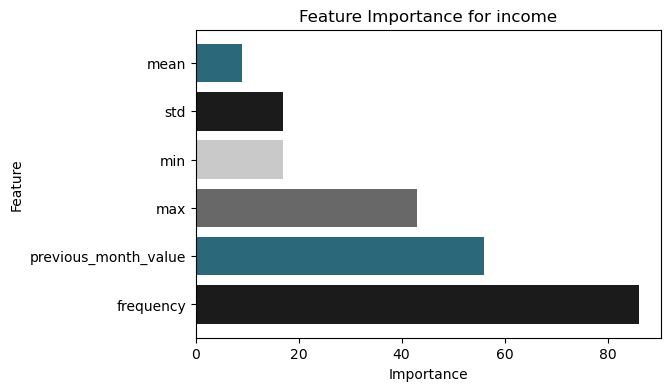

In [63]:
# Get feature importances
feature_importance = final_model_in.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for easier plotting
feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(y=feature_importance_df['Feature'], width=feature_importance_df['Importance'], color=n26_colors_hex)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for income')
plt.show()

#### Append results to the original dataframe

In [64]:
test_income['preds'] = y_pred_final_in

in_preds = test_income[['user_id', 'preds']]
in_preds.head()

,user_id,preds
5,000295594379774ab9ac2c78c946d615,124.290062
11,000aa792d73dd82b16a29692772d395a,109.387924
17,0011103fe4ba1264342882b7ab98c641,553.324707
23,001679c77c33d7efabf800596fb2a978,612.111145
29,001e72a2f4c4376f10011735dde39cd5,71.934731


In [65]:
# Save file as a csv to compare against true values from August
in_preds.to_csv('in_preds.csv')

#### Expenses

In [66]:
# Train a final model that will be used for August
X_train_expenses = train_expenses.drop(['user_id', 'out_next_month'], axis=1)
y_train_expenses = train_expenses['out_next_month']

# Prepare the testing data
X_test_expenses = test_expenses.drop(['user_id', 'out_next_month'], axis=1)

# Initialize and train the best model
final_model_out = xgb.XGBRegressor(**best_params_out)
final_model_out.fit(X_train_expenses, y_train_expenses)

# Make predictions on the test set
y_pred_final_out = final_model_in.predict(X_test_expenses)

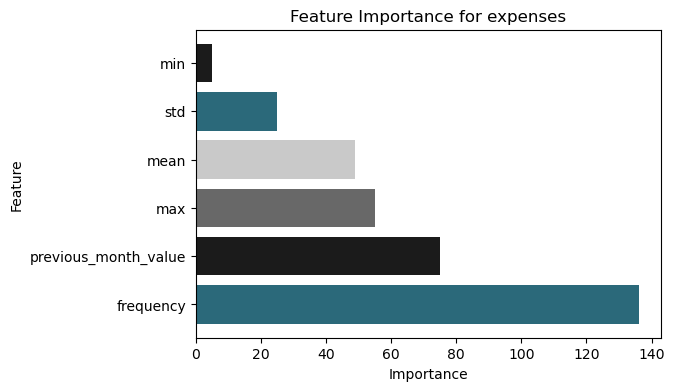

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importance = final_model_out.get_booster().get_score(importance_type="weight")

# Convert to DataFrame for easier plotting
feature_importance_df = pd.DataFrame(list(feature_importance.items()), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

# Define colors
n26_colors_hex = ['#2b697a', '#1B1B1B', '#686868', '#C9C9C9']

# Plot
plt.figure(figsize=(6, 4))
plt.barh(y=feature_importance_df['Feature'], width=feature_importance_df['Importance'], color=n26_colors_hex)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for expenses')



# Show the plot
plt.show()


In [68]:
test_expenses['preds'] = y_pred_final_out

out_preds = test_expenses[['user_id', 'preds']]
out_preds.head()

,user_id,preds
5,000295594379774ab9ac2c78c946d615,92.266701
11,000aa792d73dd82b16a29692772d395a,260.986145
17,0011103fe4ba1264342882b7ab98c641,465.867981
23,001679c77c33d7efabf800596fb2a978,677.858887
29,001e72a2f4c4376f10011735dde39cd5,74.828751


In [69]:
# Save file as a csv to compare against true values from August
out_preds.to_csv('out_preds.csv')

# 🚀&nbsp; August predictions pipeline

In [70]:
def calculate_actual_transactions(data, transactions_type, month=8):
    # Convert 'transaction_date' to datetime format and extract the month
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])
    data['month'] = data['transaction_date'].dt.month
    
    # Merge data with transactions_type to get the 'direction' for each transaction
    merged_data = pd.merge(data, transactions_type[['type', 'direction']], left_on='transaction_type', right_on='type', how='left')
    
    # Filter the data for 'In' direction based on the specified 'month'
    in_direction_data = merged_data[(merged_data['direction'] == 'In') & (merged_data['month'] == month)].copy()
    
    # Filter the data for 'Out' direction based on the specified 'month'
    out_direction_data = merged_data[(merged_data['direction'] == 'Out') & (merged_data['month'] == month)].copy()
    
    # Group by 'user_id', 'month', and sum the 'amount_n26_currency' for 'In' direction
    in_grouped_data = in_direction_data.groupby(['user_id', 'month'])['amount_n26_currency'].sum().reset_index()
    in_grouped_data.rename(columns={'amount_n26_currency': 'actual_in'}, inplace=True)
    
    # Group by 'user_id', 'month', and sum the 'amount_n26_currency' for 'Out' direction
    out_grouped_data = out_direction_data.groupby(['user_id', 'month'])['amount_n26_currency'].sum().reset_index()
    out_grouped_data.rename(columns={'amount_n26_currency': 'actual_out'}, inplace=True)
    
    # Print the baseline model (average) for each DataFrame
    print(f"Baseline prediction (average income) for month {month} is: {in_grouped_data['actual_in'].mean()}")
    print(f"Baseline prediction (average expenses) for month {month} is: {out_grouped_data['actual_out'].mean()}")
    
    return in_grouped_data, out_grouped_data

In [71]:
def calculate_prediction_errors(actual_in_data, actual_out_data):
    # Read predictions from CSV files, assuming they are always in a directory called 'Data'
    in_preds_df = pd.read_csv("in_preds.csv")
    out_preds_df = pd.read_csv("out_preds.csv")
    
    # Perform an inner join with the actual data using 'user_id'
    merged_in_data = pd.merge(actual_in_data, in_preds_df, on='user_id', how='inner')
    merged_out_data = pd.merge(actual_out_data, out_preds_df, on='user_id', how='inner')
    
    # Calculate RMSE and RMSLE for 'In' direction
    rmse_in = sqrt(mean_squared_error(merged_in_data['actual_in'], merged_in_data['preds']))
    rmsle_in = sqrt(mean_squared_log_error(merged_in_data['actual_in'], merged_in_data['preds']))
    print(f"RMSE for 'In' direction: {rmse_in}")
    print(f"RMSLE for 'In' direction: {rmsle_in}")
    
    print("#######################################")
    
    # Calculate RMSE and RMSLE for 'Out' direction
    rmse_out = sqrt(mean_squared_error(merged_out_data['actual_out'], merged_out_data['preds']))
    rmsle_out = sqrt(mean_squared_log_error(merged_out_data['actual_out'], merged_out_data['preds']))
    print(f"RMSE for 'Out' direction: {rmse_out}")
    print(f"RMSLE for 'Out' direction: {rmsle_out}")

In [72]:
def run_pipeline(data_file_path):
    transaction_types_file_path = "Data/transaction_types.csv"
    
    # Read the data and transaction_types files
    data = pd.read_csv(data_file_path)
    transaction_types = pd.read_csv(transaction_types_file_path)
    
    # Call calculate_actual_transactions to get actual 'In' and 'Out' data
    actual_in_data, actual_out_data = calculate_actual_transactions(data, transaction_types, month=7)
    
    # Call calculate_prediction_errors to get RMSE and RMSLE
    calculate_prediction_errors(actual_in_data, actual_out_data)

In [73]:
run_pipeline('Data/2016-09-19_79351_training.csv')

Baseline prediction (average income) for month 7 is: 317.8975925925926
Baseline prediction (average expenses) for month 7 is: 304.9242446358196
RMSE for 'In' direction: 232.39968711379896
RMSLE for 'In' direction: 0.85246934305441
#######################################
RMSE for 'Out' direction: 300.2956249007527
RMSLE for 'Out' direction: 1.0178524157242101


 # 🔢&nbsp; Quick overview & Enhancments

- The results obtained in this anaylsis are not good at all, sometimes the baseline models perfromed better this could be for some reasons:
    - The data is not enough, I had data from February untill July, however, I could use Feburary in my predictions because of the way I defined the time horizon that I'm preditinc users' income and expenses based on previous month transcations. I could have imputed the average for that user across whole month but that would be considered a data leakge, I could also use any zeros for that feature in the previous month, I chose not to use that month in training because imputation with zeros with very small portion of data could impact the performance
    
- The reason for focusing on RMSLE is that some users have high amount of transcations and some others not, RMSLE is less senstivie to outliers because (chatGPT please give more description here)    

# 🚀&nbsp; Steps for production

- To deploy the entire pipeline, I would create a Docker container for each component in the pipeline, including:
    - Data Validation
    - Data Preparation (Handling missing values & outliers)
    - Feature Engineering
    - Feature Selection (I skipped this step because I assumed we have a small subset of features)
    - Modeling
    - Evaluation
- I will write unit tests for each component and function to ensure reliability and consistency.
- I will perform a load test, possibly using Locust, to simulate real-world usage and ensure the system can handle the anticipated volume of requests.
- Each of these components will be encapsulated in a separate Docker container. For orchestration, I could use tools like TFX or Kubernetes to deploy them, either on cloud services like Vertex AI or on-premises.
- If the goal is to deploy only the model, I will export it, version it, and serve it as an API for easy integration and scalability.
- If the purpose of this task is to improve performance of an existing model, I will use A/B testing to evaluate both the model and business metrics. This will help us understand if the new model actually provides a measurable improvement.
- After deployment, I will create a dashboard, potentially using Tableau, to track model performance and monitor for any data or concept drift. This will allow us to respond proactively to changes and maintain the model's effectiveness over time.